In [1]:
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
import os

from tensorflow import keras
from toai.imports import *

from data import DataContainer
from image import *
from image_learner import ImageLearner
from transformations import (
    ImageParser,
    ImageCropTransformation,
    ImageLRFlpTransformation,
)
import tensorflow_addons as tfa

<IPython.core.display.Javascript object>

In [4]:
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


<IPython.core.display.Javascript object>

In [5]:
DATA_DIR = Path("data")
TEMP_DIR = Path("temp")
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

<IPython.core.display.Javascript object>

In [6]:
TRAIN_DIR = DATA_DIR / "train"
images = [
    str(TRAIN_DIR / label_dir / val)
    for label_dir in os.listdir(TRAIN_DIR)
    for val in os.listdir(TRAIN_DIR / label_dir)
]

<IPython.core.display.Javascript object>

In [7]:
train_df = pd.DataFrame()
train_df["path"] = images
train_df["label"] = train_df["path"].apply(lambda path: path.split("/")[2])

<IPython.core.display.Javascript object>

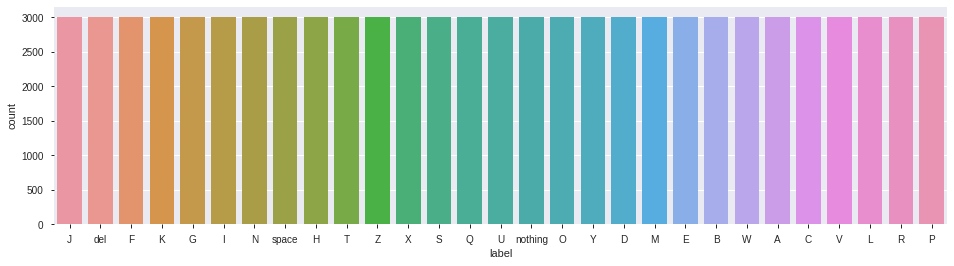

<IPython.core.display.Javascript object>

In [8]:
plt.figure(figsize=(16, 4))
sns.countplot(x="label", data=train_df)

In [9]:
TEST_DIR = DATA_DIR / "test"
test_images = [
    str(TEST_DIR / label_dir / val)
    for label_dir in os.listdir(TEST_DIR)
    for val in os.listdir(TEST_DIR / label_dir)
]

<IPython.core.display.Javascript object>

In [10]:
test_df = pd.DataFrame()
test_df["path"] = test_images
test_df["label"] = test_df["path"].apply(lambda path: path.split("/")[2])

<IPython.core.display.Javascript object>

In [11]:
test_df.head()

,path,label
0,data/test/J/J0029_test.jpg,J
1,data/test/J/J0005_test.jpg,J
2,data/test/J/J0017_test.jpg,J
3,data/test/J/J0021_test.jpg,J
4,data/test/J/J0024_test.jpg,J


<IPython.core.display.Javascript object>

In [12]:
test_df.shape

(870, 2)

<IPython.core.display.Javascript object>

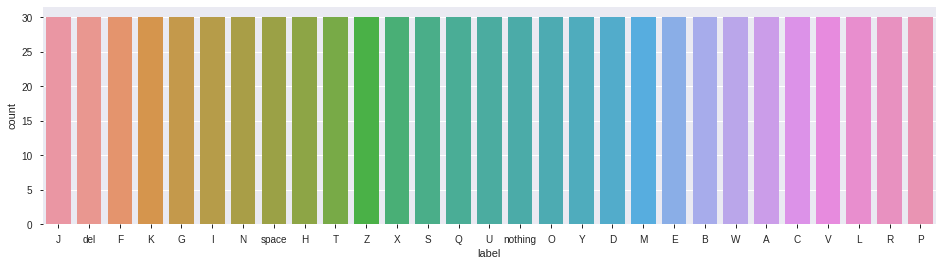

<IPython.core.display.Javascript object>

In [13]:
plt.figure(figsize=(16, 4))
sns.countplot(x="label", data=test_df)

In [14]:
IMG_DIMS = (100, 100, 3)

<IPython.core.display.Javascript object>

In [15]:
train_data, validation_data = train_test_split(train_df, test_size=0.2)

<IPython.core.display.Javascript object>

In [16]:
test_data = test_df.copy()

<IPython.core.display.Javascript object>

In [17]:
[data.shape for data in [train_data, validation_data]]

[(69600, 2), (17400, 2)]

<IPython.core.display.Javascript object>

In [18]:
base_config = ImageDatasetConfig(
    img_dims=IMG_DIMS,
    batch_size=16,
    preprocess_pipeline=[ImageParser(), ImageCropTransformation(IMG_DIMS)],
)

train_dataset = ImageDataset(
    base_config.copy(preprocess_pipeline=[ImageLRFlpTransformation()], shuffle=True)
).build_from_df(train_data, "path", "label")

data_container = DataContainer(
    train=train_dataset,
    validation=ImageDataset(
        base_config.copy(preprocess_pipeline=[ImageLRFlpTransformation()])
    )
    .with_label_map(train_dataset.label_map)
    .build_from_df(validation_data, "path", "label"),
    test=ImageDataset(
        base_config.copy(preprocess_pipeline=[ImageCropTransformation(IMG_DIMS)])
    )
    .with_label_map(train_dataset.label_map)
    .build_from_df(test_data, "path", "label"),
)

<IPython.core.display.Javascript object>

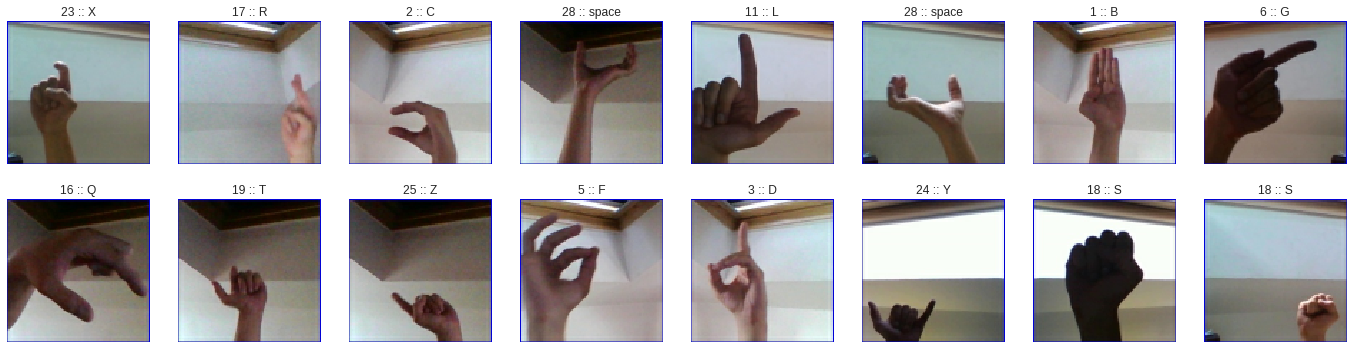

<IPython.core.display.Javascript object>

In [58]:
data_container.train.show()

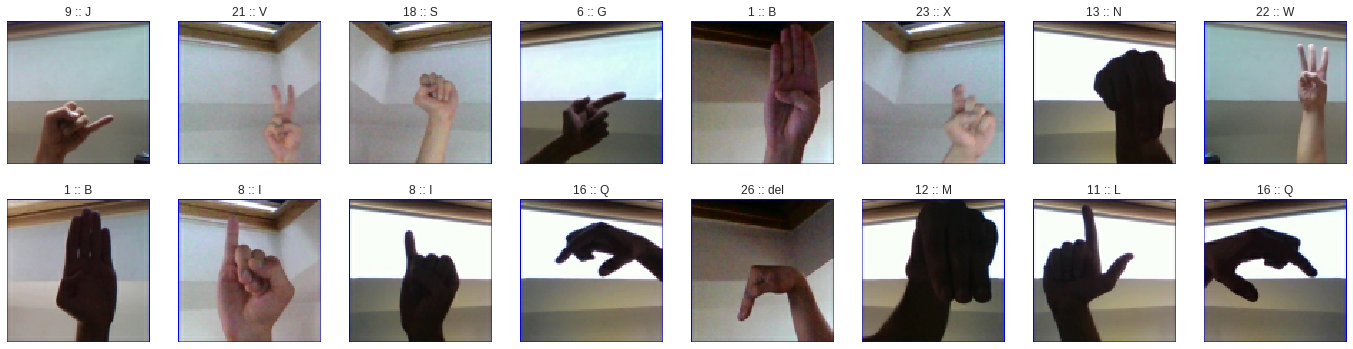

<IPython.core.display.Javascript object>

In [18]:
data_container.validation.show()

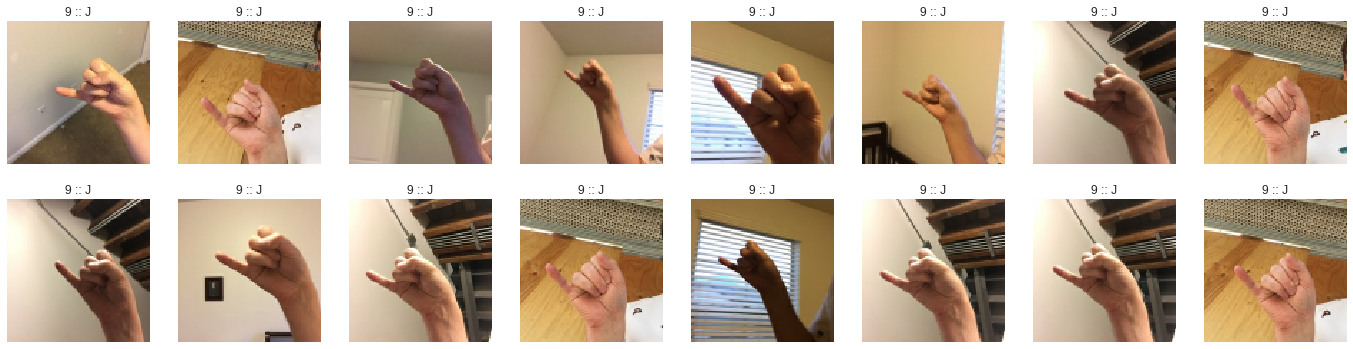

<IPython.core.display.Javascript object>

In [82]:
data_container.test.show()

In [95]:
learner = ImageLearner(
    model_path=Path(TEMP_DIR / "xception"),
    data=data_container,
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    dropout=0.3,
    activation=keras.activations.softmax,
)

Existing model data path exists
Loading architecture and weights from temp/xception
Model loaded successfully


<IPython.core.display.Javascript object>

In [96]:
learner.auto_train(
    easing_epochs=0,
    epochs=0,
    optimizer=keras.optimizers.Adam,
    lr=1e-4,
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[keras.metrics.sparse_categorical_accuracy],
)

Starting model training
Train for 4350 steps, validate for 1088 steps
Loading weights only from temp/xception/weights.h5
Model loaded successfully
Model training completed


<IPython.core.display.Javascript object>

870/870 [==============================] - 7s 8ms/step


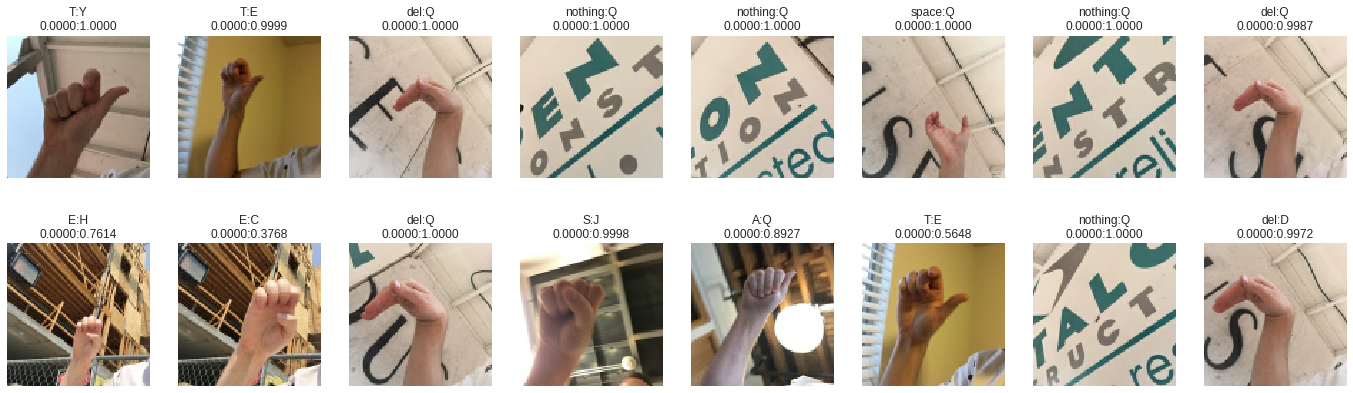

<IPython.core.display.Javascript object>

In [85]:
learner.show_predictions(mode="test", correct=False)

In [87]:
learner.evaluate_dataset(mode="validation")

[0.015819202772999072, 0.99844825]

<IPython.core.display.Javascript object>

In [88]:
learner.evaluate_dataset(mode="test")

[5.301506082374941, 0.48390806]

<IPython.core.display.Javascript object>

In [89]:
learner.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

<IPython.core.display.Javascript object>

In [98]:
learner.model = keras.Model(
    inputs=learner.base_model.input, outputs=learner.concat_layer
)

<IPython.core.display.Javascript object>

In [103]:
image_embeddings = learner.predict_dataset(mode="test", verbose=1)

55/55 [==============================] - 1s 20ms/step


<IPython.core.display.Javascript object>

In [104]:
neighbors = sk.neighbors.NearestNeighbors(n_neighbors=11, algorithm="ball_tree").fit(
    image_embeddings
)

<IPython.core.display.Javascript object>

In [105]:
new_image_index = np.random.randint(len(data_container.test.x))
new_image_index

22

<IPython.core.display.Javascript object>

In [110]:
images = tf.data.Dataset.from_tensor_slices(
    data_container.test.x[new_image_index : new_image_index + 1]
)
for fun in data_container.test.config.preprocess_pipeline:
    images = images.map(fun, num_parallel_calls=1)

images = images.batch(1)
new_image_embeddings = learner.model.predict(images)

<IPython.core.display.Javascript object>

In [111]:
distances, indices = neighbors.kneighbors(new_image_embeddings)

<IPython.core.display.Javascript object>

In [114]:
def show_distances(
    dataset,
    target_index,
    similar_indices,
    distances,
    cols: int = 4,
    debug: bool = False,
):
    if cols >= len(distances) + 1:
        cols = len(distances) + 1
        rows = 1
    else:
        rows = math.ceil((len(distances) + 1) / cols)

    figsize = (3 * cols, 4 * rows) if debug else (3 * cols, 3 * rows)
    _, ax = plt.subplots(rows, cols, figsize=figsize)

    for i, (x, y, distance) in enumerate(
        zip(
            dataset.x[[target_index] + similar_indices],
            dataset.y[[target_index] + similar_indices],
            [0] + distances,
        )
    ):
        idx = (i // cols, i % cols) if rows > 1 else i % cols
        ax[idx].axis("off")
        ax[idx].imshow(Image.open(x))
        title = f"Label: {y}\nShape: {x.shape}\n" if debug else f"{y}\n{distance:.2f}"
        ax[idx].set_title(title)

<IPython.core.display.Javascript object>

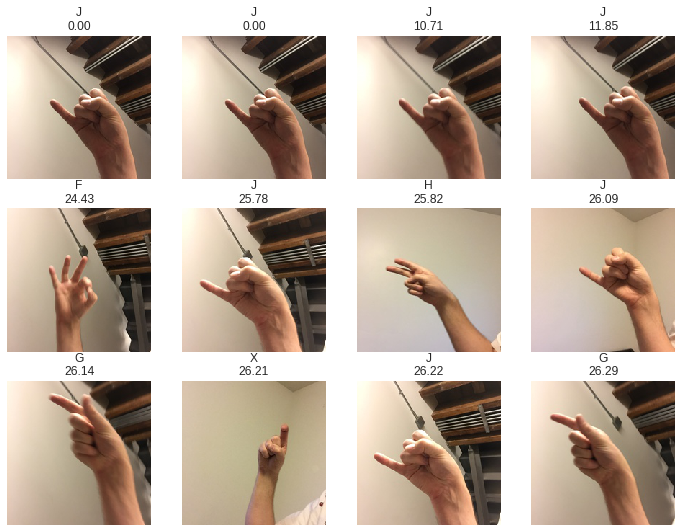

<IPython.core.display.Javascript object>

In [115]:
show_distances(
    data_container.test, new_image_index, indices[0].tolist(), distances[0].tolist()
)

In [ ]:
learner.model.summary